In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.model_selection import GridSearchCV

#### Ridge, RidgeCV, Lasso, LassoCV, GridSearchCV 함수 각각 가지고 있는 특성이 다양해서
#### 모두 사용 해보며 R glmnet의 결과와 최대한 유사한 결과를 낼 수 있는 것을 적용하였습니다.

# 분석 데이터 전처리

In [2]:
mtcars = sm.datasets.get_rdataset("mtcars")['data']

# 설명변수, 종속변수 설정
y = mtcars[['mpg']]
x = mtcars[mtcars.columns[1:]]

# centering y & standardizing x
yc = y-y.mean()
xs = (x-x.mean())/x.std()

# lambda 범위 설정
lambda_to_try = 10**np.linspace(-3, 5, 100)

# Ridge Regression

### Cross-Validation 최적 lambda, 회귀계수 계산

In [3]:
# RidgeCV 이용
ridge_cv = RidgeCV(alphas=lambda_to_try, store_cv_values=True, fit_intercept=True)
ridge_cv.fit(xs, yc)

coef = pd.DataFrame(ridge_cv.coef_, columns=xs.columns, index=['weight']).T
lambda_min = round(ridge_cv.alphas[ridge_cv.cv_values_.mean(axis=0).argmin()], 4)
mse_min = round(ridge_cv.cv_values_.mean(axis=0).min(), 4)

print('Measure: Mean-Squared Error')
print(f'Lambda   Measure Nonzero')
print(f'{lambda_min}  {mse_min}  {len(xs.columns)}')
print()
print(coef)

Measure: Mean-Squared Error
Lambda   Measure Nonzero
13.2194  7.2517  10

        weight
cyl  -0.660994
disp -0.644705
hp   -0.801517
drat  0.562270
wt   -1.231629
qsec  0.293017
vs    0.381106
am    0.823555
gear  0.403445
carb -0.902470


### R의 plot(ridge_cv)와 유사한 plotting 구현

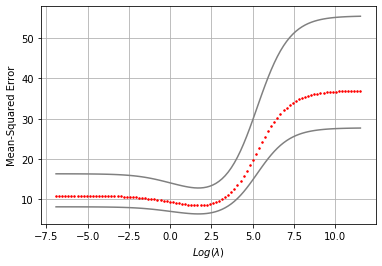

In [4]:
# GridSearchCV 사용
ridge = Ridge()
param = {'alpha': lambda_to_try}
ridge_cv = GridSearchCV(ridge, param, scoring='neg_mean_squared_error', cv=10)
ridge_cv.fit(xs, yc)

ridge_dict = ridge_cv.cv_results_

a = pd.DataFrame([ridge_dict[f'split{i}_test_score'] for i in range(10)]).T
a.index = np.log(lambda_to_try)

b = pd.DataFrame(a.std(axis=1))
b.index = np.log(lambda_to_try)
plt.plot(b, color='grey')
plt.plot(b/2, color='grey')
plt.plot(b/1.5, marker='o', ls=' ', ms=1.5, c='r')
plt.ylabel('Mean-Squared Error')
plt.xlabel(r'$Log(\lambda)$')
# plt.scatter(b.sort_values(0).head(1).index, b.sort_values(0).head(1)[0], color='red', s=5) #최소인점
plt.grid()

plt.show()

### 최적 lambda, SSE, R^2 계산

In [5]:
# Ridge 이용
lambda_cv = lambda_min

res_cv = Ridge(alpha=lambda_cv)
res_cv.fit(xs, yc)

yhat_cv = res_cv.predict(xs)
yhat_cv = pd.DataFrame(yhat_cv, columns=yc.columns, index=yc.index)
sse_cv = (yc-yhat_cv).T.dot(yc-yhat_cv)
rsq_ridge_cv = (pd.concat([yc, yhat_cv], axis=1).corr()**2).iloc[[0],[1]]

print(lambda_cv)
print(sse_cv)
print(rsq_ridge_cv)

13.2194
            mpg
mpg  170.737739
          mpg
mpg  0.853537


### AIC와 BIC를 활용하여 최적 lambda 계산

In [6]:
# Choosing lambda by AIC BIC 

# lambda 범위 재설정
lambda_to_try = 10**np.linspace(-3, 5, 100)

col = len(xs.columns)
row = len(xs.index)

AICs = []
BICs = []

for u in lambda_to_try:
    res = Ridge(alpha = u, fit_intercept=True)
    res.fit(xs,yc)

    betas = pd.DataFrame(res.coef_, columns=xs.columns)
    resid = yc - xs.dot(betas.T).rename(columns={0: yc.columns[0]})

    H = (xs.dot(np.linalg.inv(xs.T.dot(xs) + u*np.eye(col))))
    H.columns = xs.columns
    H = H.dot(xs.T)

    df = np.trace(H)

    AIC = (row * np.log(resid.T.dot(resid)) + 2*df).iloc[0,0]
    BIC = (row * np.log(resid.T.dot(resid)) + 2*df*np.log(row)).iloc[0,0]
    AICs.append(AIC)
    BICs.append(BIC)
    
betas

,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,-0.001589,-0.001581,-0.001448,0.00127,-0.001618,0.000781,0.001238,0.001119,0.000896,-0.001028


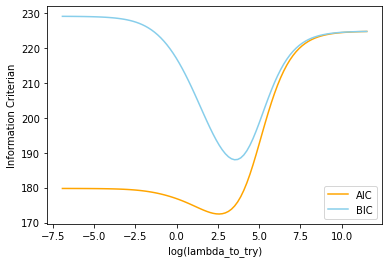

In [7]:
plt.plot(np.log(lambda_to_try), AICs, color='orange', label='AIC')
plt.plot(np.log(lambda_to_try), BICs, color='skyblue', label='BIC')
plt.ylabel('Information Criterian')
plt.xlabel('log(lambda_to_try)')
plt.legend()
plt.show()

In [8]:
# lambdas minimizing AIC and BIC
lambda_aic = lambda_to_try[np.array(AICs).argmin()]
lambda_bic = lambda_to_try[np.array(BICs).argmin()]

# Fit final models, SSE and R-squares

# AIC
res_aic = Ridge(alpha=lambda_aic)
res_aic.fit(xs, yc)

yhat_aic = res_aic.predict(xs)
yhat_aic = pd.DataFrame(yhat_aic, columns=yc.columns, index=yc.index)
sse_aic = (yc-yhat_aic).T.dot(yc-yhat_aic)
rsq_ridge_aic = (pd.concat([yc, yhat_cv], axis=1).corr()**2).iloc[[0],[1]]

print('AIC')
print(lambda_aic)
print(sse_aic)
print(rsq_ridge_aic)
print()

# BIC
res_bic = Ridge(alpha=lambda_bic)
res_bic.fit(xs, yc)

yhat_bic = res_bic.predict(xs)
yhat_bic = pd.DataFrame(yhat_bic, columns=yc.columns, index=yc.index)
sse_bic = (yc-yhat_bic).T.dot(yc-yhat_bic)
rsq_ridge_bic = (pd.concat([yc, yhat_cv], axis=1).corr()**2).iloc[[0],[1]]

print('BIC')
print(lambda_bic)
print(sse_bic)
print(rsq_ridge_bic)

AIC
13.219411484660315
            mpg
mpg  170.737754
          mpg
mpg  0.853537

BIC
33.516026509388475
            mpg
mpg  198.996363
          mpg
mpg  0.853537


### lambda 값에 따른 회귀계수 추정치 변화 plot

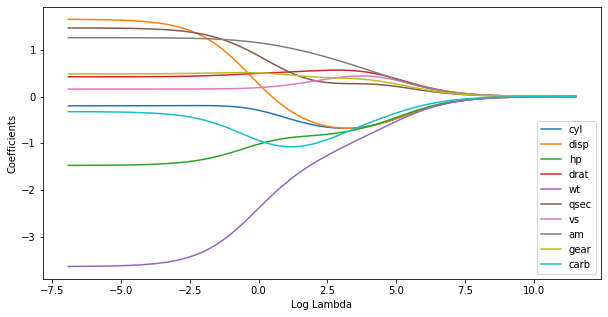

In [9]:
# shrinkage of coefficients, as lambda increase

# lambda 범위 설정
lambda_to_try = 10**np.linspace(-3, 5, 100)

coefs = pd.DataFrame(columns=xs.columns)

for k in lambda_to_try:
    ridge = Ridge(alpha=k)
    ridge.fit(xs, yc)
    
    coefs.loc[np.log(k),:] = ridge.coef_
    
coefs.plot(figsize=(10,5))
plt.legend()
plt.ylabel('Coefficients')
plt.xlabel('Log Lambda')
plt.show()

# Lasso Regression

### R의 plot(lasso_cv)와 유사한 plotting 구현

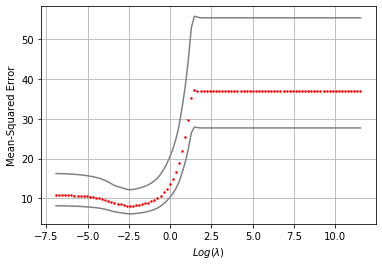

In [10]:
# GridSearchCV 사용
lasso = Lasso()
param = {'alpha': lambda_to_try}
lasso_cv = GridSearchCV(lasso, param, scoring='neg_mean_squared_error', cv=10)
lasso_cv.fit(xs, yc)

lasso_dict = lasso_cv.cv_results_

a = pd.DataFrame([lasso_dict[f'split{i}_test_score'] for i in range(10)]).T
a.index = np.log(lambda_to_try)

b = pd.DataFrame(a.std(axis=1))
b.index = np.log(lambda_to_try)
plt.plot(b, color='grey')
plt.plot(b/2, color='grey')
plt.plot(b/1.5, marker='o', ls=' ', ms=1.5, c='r')
plt.ylabel('Mean-Squared Error')
plt.xlabel(r'$Log(\lambda)$')
# plt.scatter(b.sort_values(0).head(1).index, b.sort_values(0).head(1)[0], color='red', s=5) #최소인점
plt.grid()

plt.show()

### Cross-Validation 최적 lambda, 회귀계수 계산

In [11]:
# LassoCV 이용
lasso_cv = LassoCV(alphas=lambda_to_try, cv=10)
lasso_cv.fit(xs, yc.iloc[:,0])

coef = pd.DataFrame(lasso_cv.coef_, index=xs.columns, columns=['weight'])
lambda_min = lasso_cv.alphas_[lasso_cv.mse_path_.mean(axis=1).argmin()]
print(coef)

        weight
cyl  -1.593736
disp -0.000000
hp   -0.866722
drat  0.000000
wt   -2.716156
qsec  0.000000
vs    0.000000
am    0.000000
gear  0.000000
carb -0.000000


### 최적 lambda, SSE, R^2 계산

In [12]:
# Lasso 이용
lambda_L_cv = lambda_min

res_cv = Lasso(alpha=lambda_L_cv)
res_cv.fit(xs, yc)

yhat_L_cv = res_cv.predict(xs)
yhat_L_cv = pd.DataFrame(yhat_L_cv, columns=yc.columns, index=yc.index)
sse_L_cv = (yc-yhat_L_cv).T.dot(yc-yhat_L_cv)
rsq_L_cv = (pd.concat([yc, yhat_L_cv], axis=1).corr()**2).iloc[[0],[1]]

print(lambda_L_cv)
print(sse_L_cv)
print(rsq_L_cv)

0.6734150657750828
            mpg
mpg  194.735022
          mpg
mpg  0.842671


### lambda 값에 따른 회귀계수 추정치 변화 plot

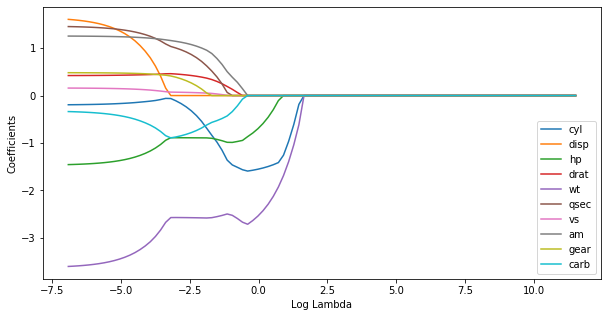

In [13]:
# shrinkage of coefficients, as lambda increase

# lambda 범위 설정
lambda_to_try = 10**np.linspace(-3, 5, 100)

coefs = pd.DataFrame(columns=xs.columns)

for k in lambda_to_try:
    lasso = Lasso(alpha=k)
    lasso.fit(xs, yc)
    
    coefs.loc[np.log(k),:] = lasso.coef_
    
coefs.plot(figsize=(10,5))
plt.legend()
plt.ylabel('Coefficients')
plt.xlabel('Log Lambda')
plt.show()